### Author: Frederick Tan
### Student ID: 16227617
### Assignment Number: 4

In [89]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pylab as py
import seaborn as sns
import json
import urllib
import tabulate
from bs4 import BeautifulSoup
from pylab import rcParams
from IPython.display import HTML, display

%matplotlib inline
sns.set(style="ticks")
matplotlib.style.use('ggplot')

# Introduction

From the assignment description: "Gravitational (micro)lensing occurs when a foreground star (the lens) passes along the line-of-sight of a background star (the source). A consequence of Einstein's theory of general relativity is that light rays do not always travel in straight lines. A light ray will follow the natural "curvature" of space-time if it passes by an object that has mass. The result of this is that the foreground star acts as a lens on the background star. The lens star will produce two
arc shaped images of the source star. More complicated image patterns are produced if there are several lens stars."

The assignment requirement is to write a GPU implementation of the algorithm to derive the source image positions.

# System Configuration

The important configuration regarding the GPU on the test machine is described below:

In [90]:
table = [['GPU Card', 'Quadro K600'],
         ['CUDA Driver Version', '10.0'],
         ['Runtime Version', '10.0'],
         ['CUDA Capability Version', '3.0'],
         ['Global memory', '980 MBytes'],
         ['Processor', '1'],
         ['CUDA Cores/MP', '192'],
         ['Amount of shared memory per block', '49152 bytes'],
         ['Maximum number of threads per multiprocessor', '2048'],
         ['Maximum number of threads per block', '1024'],
         ['Max dimension size of a thread block (x,y,z)', '(1024, 1024, 64)'],
         ['Max dimension size of a grid size (x,y,z)', '(2147483647, 65535, 65535)']]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

# Code Implementation

The GPU implementation modeled the pixels as threads. The pixel array is passed between the host and the device. The maximum size used in the test is 256MB. Other memory allocation includes the arrays for x and y positions, and the eps. All in all, this is far from the 980MB available in the GPU card.

There was a missed opportunity for creating a child kernel for processing the lens data, but the author decided not to do it as he was unsure if it is a version dependent feature. The number of lenses is also typically nigligible compared to the number of pixels.

# Processing the Data

In [119]:
df_parallel = pd.read_csv('./result/result.parallel', names=['BPG', 'TPB', 'NPixel', 'LScale', 'NLenses', 'TotalTime',
                                                             'PrepareDeviceTime', 'CopyToDeviceTime', 'CopyFromDeviceTime'])
df_base = pd.read_csv('./result/result.base', names=['NPixel', 'LScale', 'NLenses', 'TotalTime'])

In [124]:
df_base_g = df_base[df_base.NPixel != 7112889].groupby('NPixel').mean().reset_index()

In [125]:
df_parallel_g = df_parallel[df_parallel.NPixel != 7112889].groupby(['NPixel', 'BPG', 'TPB']).mean().reset_index()
df_parallel_g = df_parallel_g.sort_values(by = ['NPixel', 'TPB']).reset_index(drop = True)

## Figure 1.1: Control v.s. GPU with Different Thread Numbers

In [126]:
df_parallel_g_v02 = df_parallel_g[df_parallel_g.LScale > 0.0011]

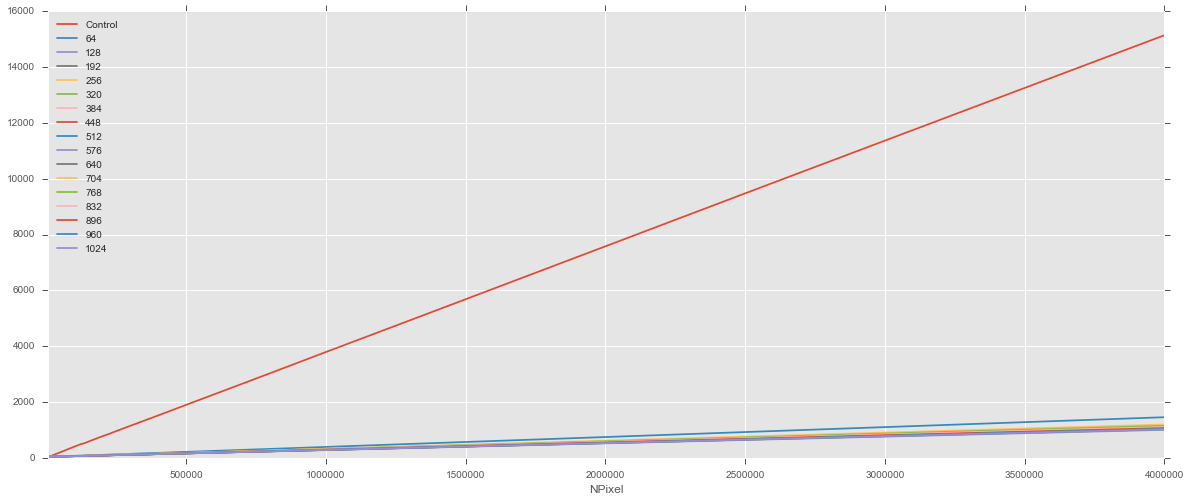

In [127]:
fig, ax = plt.subplots(figsize=(20,8))

df_base_g.plot(x='NPixel', y='TotalTime', label='Control', ax=ax)
for nth in df_parallel_g.TPB.unique():
    df_parallel_g_v02[df_parallel_g_v02.TPB == nth].plot(x='NPixel', y='TotalTime', label=nth, ax=ax)

In this figure, the parallel data was reduced to match the number of test points corresponding to the controlled data. You can clearly see the performance boost here. 

## Figure 1.2: GPU Performance with Different Thread Numbers

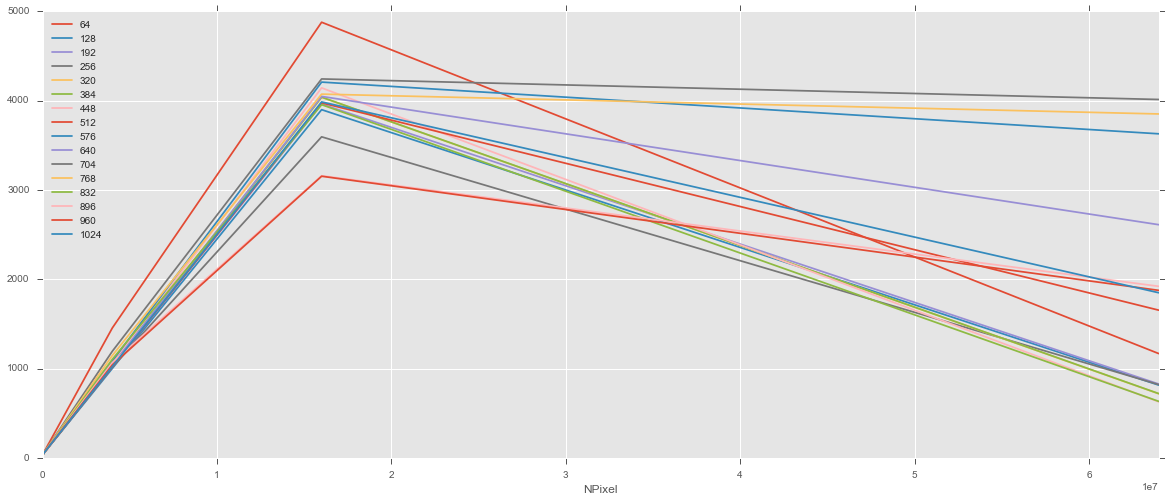

In [128]:
fig, ax = plt.subplots(figsize=(20,8))

for nth in df_parallel_g.TPB.unique():
    df_parallel_g[df_parallel_g.TPB == nth].plot(x='NPixel', y='TotalTime', label=nth, ax=ax)

## Thread Performance Ranking

In [154]:
df_parallel.groupby(
    'TPB').mean().drop(
    ['BPG', 'NPixel', 'CopyToDeviceTime', 'CopyFromDeviceTime',
     'PrepareDeviceTime', 'LScale', 'NLenses'],
     axis=1).sort_values(by='TotalTime')

TotalTime
TPB             
960   132.400563
256   133.853140
896   134.020100
128   135.917042
192   137.831145
320   139.204728
384   139.310168
1024  139.485285
512   140.222299
448   141.676299
832   142.028251
640   144.820699
576   152.143592
768   155.189430
704   160.270213
64    174.977914

In [150]:
df_parallel.groupby(
    'TPB').mean().drop(
    ['BPG', 'NPixel', 'CopyToDeviceTime', 'CopyFromDeviceTime',
     'PrepareDeviceTime', 'LScale', 'NLenses'],
     axis=1).rank().sort_values(
     by='TotalTime').reset_index().rename(
     columns={'TotalTime' : 'TotalTimeRank',
             'TPB' : 'Number of Threads per Block'}).set_index('TotalTimeRank')

Number of Threads per Block
TotalTimeRank                             
1                                      960
2                                      256
3                                      896
4                                      128
5                                      192
6                                      320
7                                      384
8                                     1024
9                                      512
10                                     448
11                                     832
12                                     640
13                                     576
14                                     768
15                                     704
16                                      64

The performance improvement vs the thread count is inconclusive.

## Figure 2.1: Breaking Down the Timing Data (Total Time < 1000)

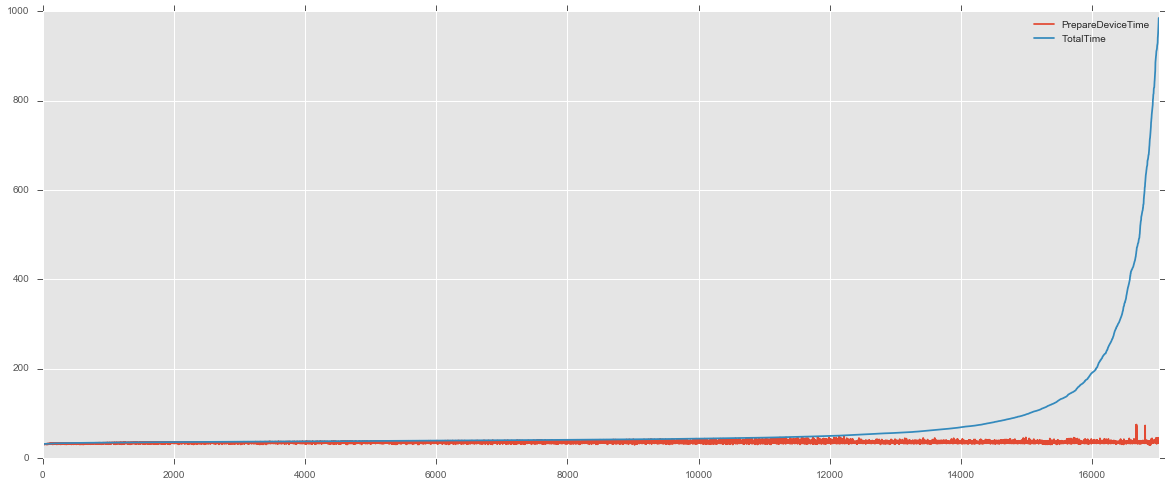

In [142]:
fig, ax = plt.subplots(figsize=(20,8))

df_parallel[df_parallel.TotalTime < 1000].sort_values(by='TotalTime').reset_index(drop=True).plot(y='PrepareDeviceTime', ax=ax)
df_parallel[df_parallel.TotalTime < 1000].sort_values(by='TotalTime').reset_index(drop=True).plot(y='TotalTime', ax=ax)

## Figure 2.2: Breaking Down the Timing Data (Total Time >= 1000)

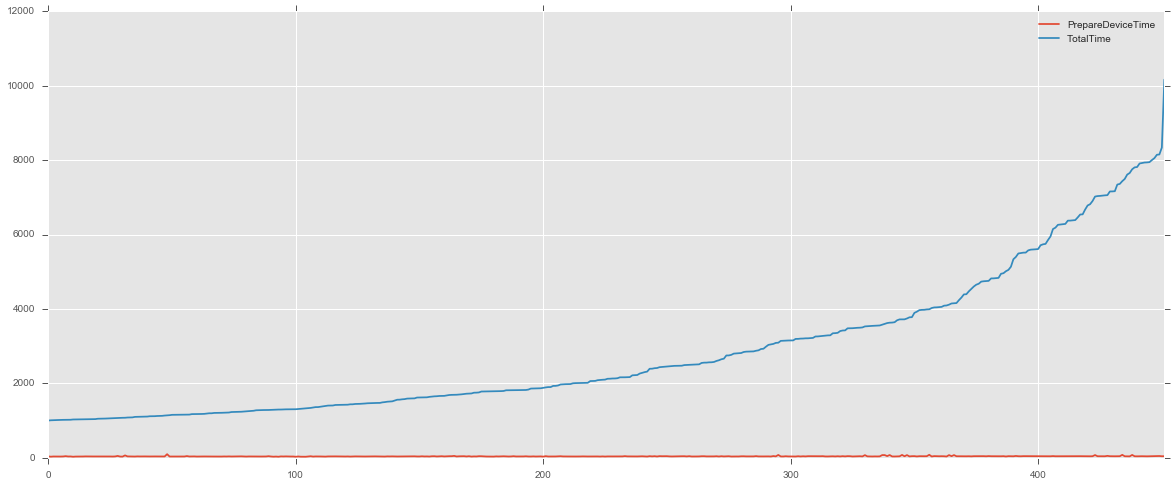

In [143]:
fig, ax = plt.subplots(figsize=(20,8))

df_parallel[df_parallel.TotalTime >= 1000].sort_values(by='TotalTime').reset_index(drop=True).plot(y='PrepareDeviceTime', ax=ax)
df_parallel[df_parallel.TotalTime >= 1000].sort_values(by='TotalTime').reset_index(drop=True).plot(y='TotalTime', ax=ax)

In [137]:
print('Total Time (mean): ', df_parallel.TotalTime.mean())

('Total Time (mean): ', 143.96102662010514)


In [138]:
print('Prepare device (mean)', df_parallel.PrepareDeviceTime.mean())

('Prepare device (mean)', 34.8199789901533)


# Analysis and Conclusion

The performance improvement when using GPU is drastic. With the smaller number of pixels, the performance improvement is not as drastic. The bulk of the improvement goes to the preparation of the device, which includes allocation of memory for the device variables, and copying initial values to these device variables.

With the number of pixels increased dramatically, the effect of this delay becomes negligible. This is best shown in figures 2.1 and 2.2.

Figure 1.2 is interesting as the performance improved after hitting a number of pixels threshold.